<a href="https://colab.research.google.com/github/ngcheeyuan/Classification_projects/blob/main/Kaggle_Credit_Card_Fraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download mlg-ulb/creditcardfraud

creditcardfraud.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
! unzip creditcardfraud.zip

Archive:  creditcardfraud.zip
replace creditcard.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [8]:
df = pd.read_csv('creditcard.csv')

In [9]:
column_names = [x.lower() for x in  df.columns.tolist()]

In [10]:
df.rename(columns = dict(zip(df.columns,column_names)) , inplace = True)

In [11]:
df['class'].mean() , 1-df['class'].mean() # class imbalance, > 0.2% positive class

(0.001727485630620034, 0.9982725143693799)

In [12]:
df.isna().sum() # no null values

time      0
v1        0
v2        0
v3        0
v4        0
v5        0
v6        0
v7        0
v8        0
v9        0
v10       0
v11       0
v12       0
v13       0
v14       0
v15       0
v16       0
v17       0
v18       0
v19       0
v20       0
v21       0
v22       0
v23       0
v24       0
v25       0
v26       0
v27       0
v28       0
amount    0
class     0
dtype: int64

In [13]:
df.loc[df.duplicated(keep='first')] # 1081 rows of duplicated data

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,amount,class
33,26.0,-0.529912,0.873892,1.347247,0.145457,0.414209,0.100223,0.711206,0.176066,-0.286717,-0.484688,0.872490,0.851636,-0.571745,0.100974,-1.519772,-0.284376,-0.310524,-0.404248,-0.823374,-0.290348,0.046949,0.208105,-0.185548,0.001031,0.098816,-0.552904,-0.073288,0.023307,6.14,0
35,26.0,-0.535388,0.865268,1.351076,0.147575,0.433680,0.086983,0.693039,0.179742,-0.285642,-0.482474,0.871800,0.853447,-0.571822,0.102252,-1.519991,-0.285912,-0.309633,-0.403902,-0.823743,-0.283264,0.049526,0.206537,-0.187108,0.000753,0.098117,-0.553471,-0.078306,0.025427,1.77,0
113,74.0,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,-0.243289,0.578063,0.674730,-0.534231,0.446601,1.122885,-1.768001,1.241157,-2.449500,-1.747255,-0.335520,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0
114,74.0,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,-0.243289,0.578063,0.674730,-0.534231,0.446601,1.122885,-1.768001,1.241157,-2.449500,-1.747255,-0.335520,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0
115,74.0,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,-0.243289,0.578063,0.674730,-0.534231,0.446601,1.122885,-1.768001,1.241157,-2.449500,-1.747255,-0.335520,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282987,171288.0,1.912550,-0.455240,-1.750654,0.454324,2.089130,4.160019,-0.881302,1.081750,1.022928,0.005356,-0.541998,0.745036,-0.375165,-0.068227,-0.795939,-0.497901,-0.134224,-1.004958,0.086074,-0.207620,-0.524067,-1.337510,0.473943,0.616683,-0.283548,-1.084843,0.073133,-0.036020,11.99,0
283483,171627.0,-1.464380,1.368119,0.815992,-0.601282,-0.689115,-0.487154,-0.303778,0.884953,0.054065,-0.828015,-1.192581,0.944989,1.372532,-0.036493,-0.208747,0.320086,-0.204910,-0.024821,-0.468859,0.031950,0.287217,0.947825,-0.218773,0.082926,0.044127,0.639270,0.213565,0.119251,6.82,0
283485,171627.0,-1.457978,1.378203,0.811515,-0.603760,-0.711883,-0.471672,-0.282535,0.880654,0.052808,-0.830603,-1.191774,0.942870,1.372621,-0.037988,-0.208490,0.321883,-0.205951,-0.025225,-0.468427,0.023667,0.284205,0.949659,-0.216949,0.083250,0.044944,0.639933,0.219432,0.116772,11.93,0
284191,172233.0,-2.667936,3.160505,-3.355984,1.007845,-0.377397,-0.109730,-0.667233,2.309700,-1.639306,-1.449823,-0.508930,0.600035,-0.627313,1.017499,-0.887384,0.420096,1.856497,1.315099,1.096112,-0.821707,0.391483,0.266536,-0.079853,-0.096395,0.086719,-0.451128,-1.183743,-0.222200,55.66,0


In [14]:
df.drop(df.loc[df.duplicated(keep = 'first')].index , inplace = True) # removing duplicates

In [15]:
df.loc[df['amount']<=0].head(5)

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,amount,class
383,282.0,-0.356466,0.725418,1.971749,0.831343,0.369681,-0.107776,0.751610,-0.120166,-0.420675,-0.059943,-0.508270,0.425506,0.414309,-0.698375,-1.465349,-0.119009,-0.144735,-1.332221,-1.547440,-0.133602,0.020804,0.424312,-0.015989,0.466754,-0.809962,0.657334,-0.043150,-0.046401,0.0,0
514,380.0,-1.299837,0.881817,1.452842,-1.293698,-0.025105,-1.170103,0.861610,-0.193934,0.592001,0.241979,0.144973,-0.583891,-1.595345,0.032613,0.752834,-0.094286,-0.163427,-1.111176,-1.124025,0.065979,-0.272563,-0.360853,0.223911,0.598930,-0.397705,0.637141,0.234872,0.021379,0.0,0
534,403.0,1.237413,0.512365,0.687746,1.693872,-0.236323,-0.650232,0.118066,-0.230545,-0.808523,0.511284,-0.178159,0.762909,1.700923,-0.133861,0.402418,0.684668,-0.609395,-0.704277,-0.720726,-0.006716,-0.077543,-0.178220,0.038722,0.471218,0.289249,0.871803,-0.066884,0.012986,0.0,0
541,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,-2.772272,3.202033,-2.899907,-0.595222,-4.289254,0.389724,-1.140747,-2.830056,-0.016822,0.416956,0.126911,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.0,1
575,430.0,-1.860258,-0.629859,0.966570,0.844632,0.759983,-1.481173,-0.509681,0.540722,-0.733623,-0.371622,0.859741,0.372609,-1.240185,0.998391,-0.346387,-0.391679,0.348289,0.282125,1.165893,0.320450,0.268028,0.125515,-0.225029,0.586664,-0.031598,0.570168,-0.043007,-0.223739,0.0,0


In [16]:
df.drop(df.loc[df['amount']<=0].index , inplace = True) # remove transaction amounts <= 0 

### Baseline model

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [18]:
X = df.drop(columns = 'class' , axis = 'columns')
y = df['class']
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size = 0.25 , random_state = 42 , shuffle = False)
X_train, X_val, y_train,y_val = train_test_split(X,y,test_size = 0.25 , random_state = 42 , shuffle = False)

In [19]:
model = LogisticRegression(solver = 'saga', penalty = 'l1',tol = 0.01,class_weight = 'balanced')
model.fit(X_train,y_train)

train_preds = model.predict(X_train)
val_preds = model.predict(X_val)

f1_score(y_train,train_preds) , f1_score(y_val,val_preds)

(0.016215433618068625, 0.008016032064128256)

In [20]:
confusion_matrix(y_train,train_preds)

array([[190885,  20191],
       [   194,    168]])

In [21]:
confusion_matrix(y_val,val_preds)

array([[68989,  1405],
       [   80,     6]])

# EDA

In [22]:
df = pd.concat([X_train,y_train], axis = 1)

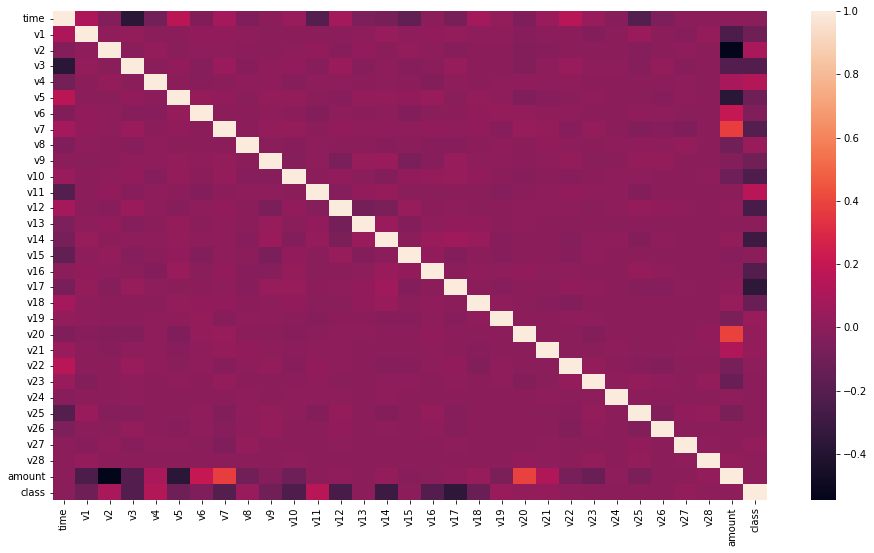

In [23]:
plt.figure(figsize = (16,9))
sns.heatmap(df.corr()) # there are some features that are relatively highly correlated with amount 

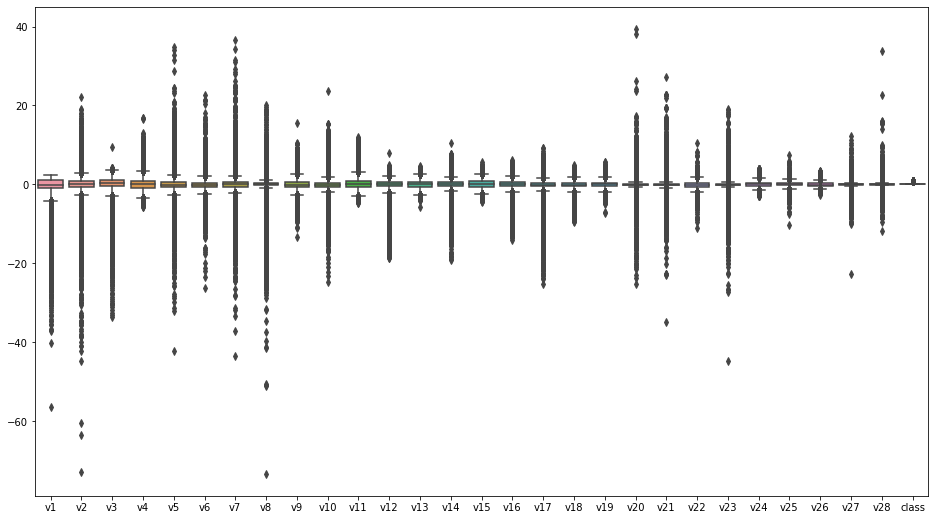

In [24]:
plt.figure(figsize = (16,9))
sns.boxplot(data=df.drop(columns = ['amount','time']))

<Figure size 1152x648 with 0 Axes>

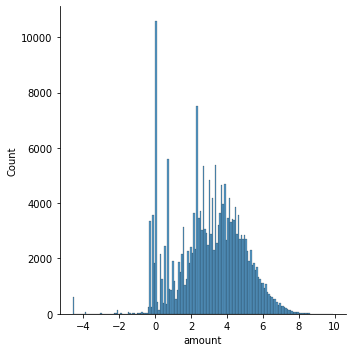

In [25]:
plt.figure(figsize=(16,9))
sns.displot(np.log(df['amount']))

In [26]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

In [27]:
'''
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

model = model.fit(pd.concat([X_train,X_val,X_test] , axis = 0))
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

''' 
# insufficient ram


'\ndef plot_dendrogram(model, **kwargs):\n    # Create linkage matrix and then plot the dendrogram\n\n    # create the counts of samples under each node\n    counts = np.zeros(model.children_.shape[0])\n    n_samples = len(model.labels_)\n    for i, merge in enumerate(model.children_):\n        current_count = 0\n        for child_idx in merge:\n            if child_idx < n_samples:\n                current_count += 1  # leaf node\n            else:\n                current_count += counts[child_idx - n_samples]\n        counts[i] = current_count\n\n    linkage_matrix = np.column_stack(\n        [model.children_, model.distances_, counts]\n    ).astype(float)\n\n    # Plot the corresponding dendrogram\n    dendrogram(linkage_matrix, **kwargs)\n\nmodel = model.fit(pd.concat([X_train,X_val,X_test] , axis = 0))\nplt.title("Hierarchical Clustering Dendrogram")\n# plot the top three levels of the dendrogram\nplot_dendrogram(model, truncate_mode="level", p=3)\nplt.xlabel("Number of points in

In [31]:
from sklearn.ensemble import IsolationForest

In [34]:
adif =IsolationForest(contamination = y_train.mean()).fit(X = X_train)
train_preds = adif.predict(X_train)
val_preds  =adif.predict(X_val)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


In [47]:
#code for plots https://www.kaggle.com/vinayaktiwari28/credit-card-fraud-detection

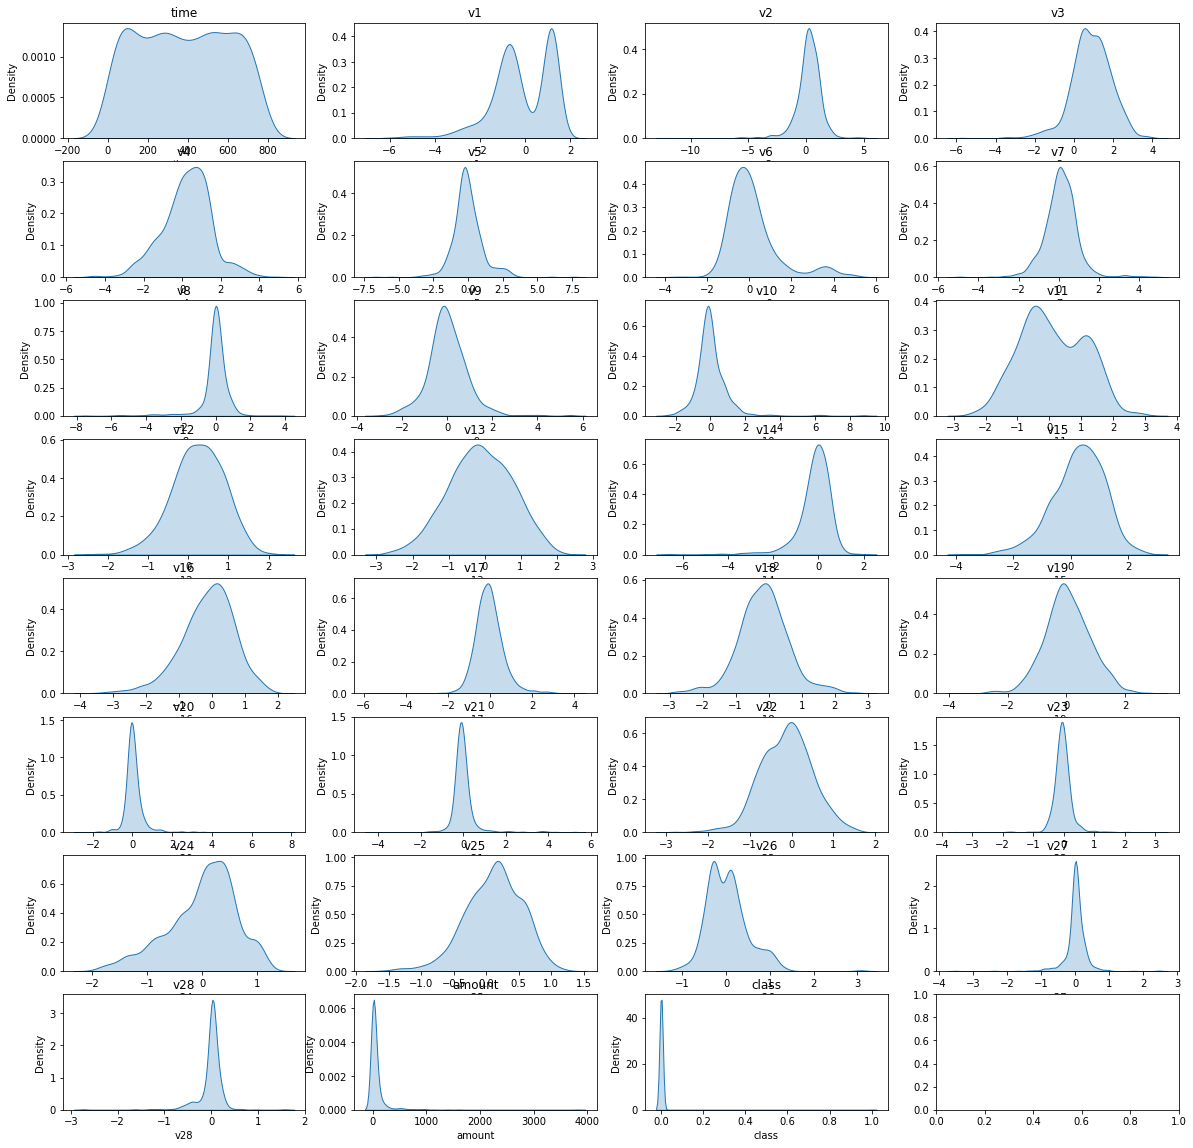

In [57]:
dffig, axes = plt.subplots(8,4, figsize=(20, 20))
axes = axes.flatten()

for ax,i in zip(axes,df.iloc[:1000].columns):
    sns.kdeplot(data= df.iloc[:1000][i], ax=ax, fill=True,warn_singular=False)
    ax.set_title(i)
plt.show()

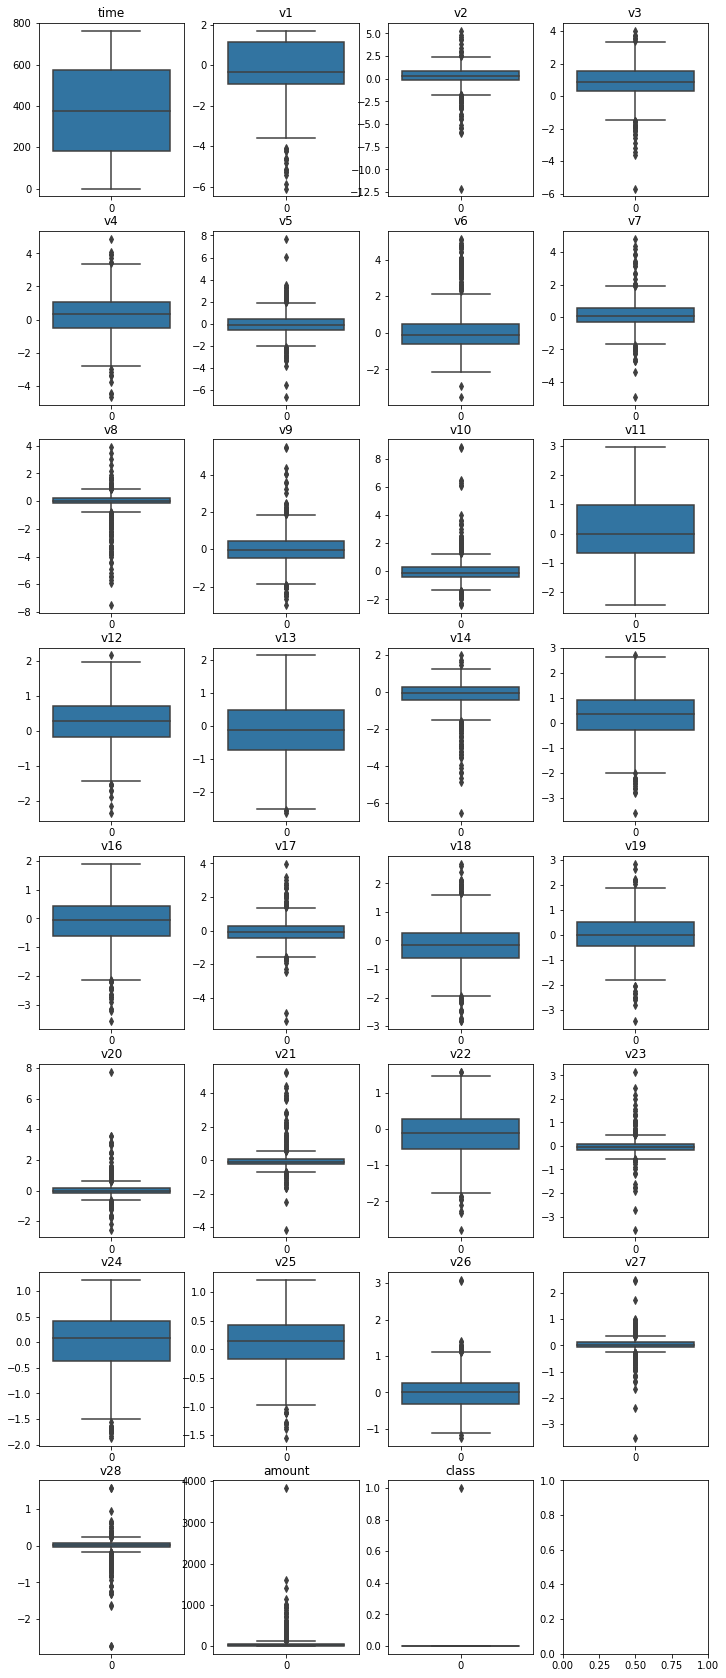

In [58]:
s,ax = plt.subplots(8,4,figsize = (12,30))
ax = ax.flatten()
for i,ax in zip(df.iloc[:,:1000].columns,ax):
      sns.boxplot(data= df.iloc[:1000][i], ax=ax)
      ax.set_title(i)
plt.show()

In [59]:
df.describe()

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,amount,class
count,211438.000000,211438.000000,211438.000000,211438.000000,211438.000000,211438.000000,211438.000000,211438.000000,211438.000000,211438.000000,211438.000000,211438.000000,211438.000000,211438.000000,211438.000000,211438.000000,211438.000000,211438.000000,211438.000000,211438.000000,211438.000000,211438.000000,211438.000000,211438.000000,211438.000000,211438.000000,211438.000000,211438.000000,211438.000000,211438.000000,211438.000000
mean,74867.013612,-0.076315,-0.011225,0.246720,0.043171,-0.085045,0.036881,-0.031802,0.009478,0.005072,-0.009230,0.103617,-0.056473,0.027723,0.041363,0.071460,-0.006375,0.021572,-0.024562,-0.008822,0.015906,-0.010974,-0.035795,-0.013002,0.002979,0.047876,0.002859,0.002508,0.002619,90.914067,0.001712
std,37141.638532,1.898243,1.627119,1.457610,1.392288,1.358635,1.315163,1.201880,1.182904,1.126944,1.078546,1.032357,1.066006,1.024870,0.958160,0.936581,0.882250,0.869755,0.840708,0.816526,0.758648,0.720600,0.698508,0.614978,0.604849,0.500431,0.487533,0.389450,0.324453,249.630387,0.041342
min,0.000000,-56.407510,-72.715728,-33.680984,-5.683171,-42.147898,-26.160506,-43.557242,-73.216718,-13.320155,-24.588262,-4.797473,-18.683715,-5.791881,-19.214325,-4.498945,-14.129855,-25.162799,-9.498746,-7.213527,-25.222345,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-11.710896,0.010000,0.000000
25%,46031.250000,-0.949855,-0.595892,-0.462272,-0.816372,-0.766018,-0.722027,-0.567763,-0.189156,-0.664485,-0.523344,-0.651982,-0.466031,-0.643584,-0.377318,-0.519367,-0.479046,-0.449451,-0.514066,-0.480052,-0.197976,-0.226655,-0.536775,-0.167901,-0.345986,-0.259059,-0.332016,-0.068250,-0.044897,6.260000,0.000000
50%,70178.500000,-0.056174,0.070399,0.428479,0.051075,-0.144647,-0.231618,0.003443,0.036465,-0.071634,-0.098925,0.052759,0.115369,0.006617,0.070790,0.152123,0.059975,-0.039723,-0.027843,-0.008301,-0.046841,-0.039257,-0.024091,-0.025912,0.050081,0.088293,-0.064189,0.004729,0.017268,23.880000,0.000000
75%,113166.000000,1.228871,0.777928,1.181481,0.844433,0.501123,0.432804,0.521123,0.332572,0.619988,0.443996,0.872429,0.611151,0.697510,0.509428,0.750895,0.528624,0.414967,0.472497,0.468239,0.148284,0.160223,0.447226,0.121337,0.424880,0.378352,0.254711,0.089427,0.078162,80.000000,0.000000
max,139339.000000,2.454930,22.057729,9.382558,16.875344,34.801666,22.529298,36.677268,20.007208,15.594995,23.745136,12.018913,7.848392,4.569009,10.526766,5.784514,6.098529,9.253526,5.041069,5.591971,39.420904,27.202839,10.503090,19.002942,4.022866,7.519589,3.517346,12.152401,33.847808,19656.530000,1.000000
